In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score,recall_score,f1_score

In [18]:
df = pd.read_csv('thesisbangladataset.csv')
x = df['cleaned'].values
y = df['Label'].values

In [19]:
df.shape

(11326, 4)

In [20]:
df.head()

,Unnamed: 0,cleaned,Class,Label
0,0,এলাকায় আসিস খুন করে ফেলে রাখবো তকে আমারে ত চিন...,AG,1
1,1,কুরআন কিতাব টাই তো ভুল এবং অন্য ধর্ম থেকে ঝাড়া...,AG,1
2,2,বাংলাদেশি খেলোয়ারদের সাথে খারাপ আচরনের জন্য আই...,NoAG,0
3,3,তুই ভুলে যাইস না আগের কথা সামনে পাইলে কিন্তু ছ...,AG,1
4,4,কেনো শুধু শুধু অন্যের ঘাড়ে পা রেখে উপরে উঠতে চ...,NoAG,0


In [39]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

# Split dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [40]:
# Tokenization and Padding
max_words = 10000  # Maximum number of words to keep in the vocabulary
max_seq_length = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned'])

X_train = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

y_train = train_df['label_encoded']
y_test = test_df['label_encoded']

In [41]:
# Build LSTM Model
embedding_dim = 100  # Dimension of the word embeddings
lstm_units = 172  # Number of LSTM units

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=64, callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10
128/128 [==============================] - 70s 526ms/step - loss: 0.6940 - accuracy: 0.5135 - val_loss: 0.6948 - val_accuracy: 0.4603
Epoch 2/10
128/128 [==============================] - 68s 535ms/step - loss: 0.6902 - accuracy: 0.5081 - val_loss: 0.6900 - val_accuracy: 0.4636
Epoch 3/10
128/128 [==============================] - 70s 543ms/step - loss: 0.6863 - accuracy: 0.5250 - val_loss: 0.6972 - val_accuracy: 0.4592
Epoch 4/10
128/128 [==============================] - 70s 544ms/step - loss: 0.6737 - accuracy: 0.5294 - val_loss: 0.6837 - val_accuracy: 0.4603
Epoch 5/10
128/128 [==============================] - 70s 548ms/step - loss: 0.6723 - accuracy: 0.5213 - val_loss: 0.6729 - val_accuracy: 0.5706
Epoch 6/10
128/128 [==============================] - 70s 550ms/step - loss: 0.6673 - accuracy: 0.5313 - val_loss: 0.6664 - val_accuracy: 0.5717
Epoch 7/10
128/128 [==============================] - 70s 549ms/step - loss: 0.6033 - accuracy: 0.6269 - val_loss: 0.3920 - val_ac

71/71 [==============================] - 5s 64ms/step
Precision: 0.8789, Recall: 0.8693, F1-Score: 0.8741
AUC-ROC Score: 0.9442


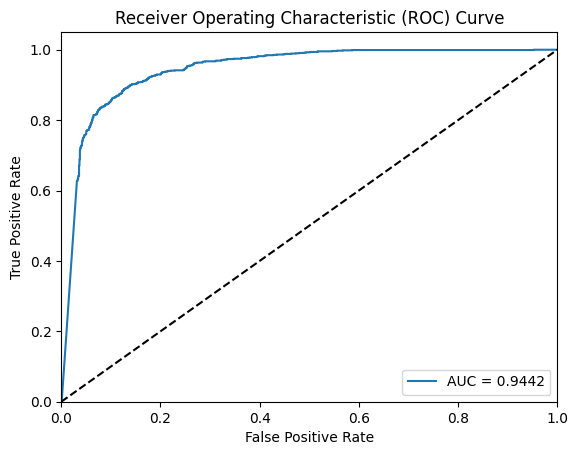

In [43]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

# Calculate and print precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC Score: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [44]:
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# ... (code for data preprocessing and model training)

# Save the model, tokenizer, and label encoder using pickle
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump((model, tokenizer, label_encoder), f)

print("Model, tokenizer, and label encoder saved successfully.")

# Now, to load the pickled model, tokenizer, and label encoder and use them for predictions:

# Load the pickled objects
with open('lstm_model.pkl', 'rb') as f:
    model, tokenizer, label_encoder = pickle.load(f)

# Take user input for a text
text_input = input("Enter the text for prediction: ")

# Preprocess the text similar to the training data
input_sequence = tokenizer.texts_to_sequences([text_input])
input_sequence = pad_sequences(input_sequence, maxlen=max_seq_length, padding='post', truncating='post')

# Make the prediction
output = model.predict(input_sequence)

# Decode the output label
predicted_label = label_encoder.inverse_transform([1 if output > 0.5 else 0])

# Print the predicted label
print(f"The input text is classified as: {predicted_label[0]}")


Model, tokenizer, and label encoder saved successfully.


Enter the text for prediction:  তুই ভুলে যাইস না আমি কে এতো বাড়াবাড়ি করলে খবর আছে কইলাম তর


1/1 [==============================] - 0s 312ms/step
The input text is classified as: 1


# Here 1 is spam and 0 is non spam